Interacting Proteins

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

import sys
sys.path.append('C:\\Users\\brittany henderson\\GitHub\\WhenMutationsDontMatter\\')
import plot_utils as p

In [2]:
gbm = cptac.Gbm()
endo = cptac.Endometrial()

cptac warning: This data is under a publication embargo until March 01, 2021. CPTAC is a community resource project and data are made available rapidly after generation for community research use. The embargo allows exploring and utilizing the data, but analysis may not be published until after the embargo date. Please see https://proteomics.cancer.gov/data-portal/about/data-use-agreement or enter cptac.embargo() to open the webpage for more details. (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 1)


In [3]:
ip = u.get_interacting_proteins('PTEN')
len(ip)

28

In [4]:
gene = 'PTEN'

In [6]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot_and_mutations = gbm.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'CNV', omics_genes = ip) 
prot_and_mutations[['PTEN_Mutation_Status','PTEN_CNV']]

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


Name,PTEN_Mutation_Status,PTEN_CNV
Patient_ID,,
C3L-00104,Single_mutation,-0.720422
C3L-00365,Wildtype_Tumor,-0.656854
C3L-00674,Single_mutation,-0.341251
C3L-00677,Single_mutation,-0.685002
C3L-01040,Wildtype_Tumor,-0.542862
...,...,...
C3N-03183,Single_mutation,-0.601062
C3N-03184,Wildtype_Tumor,-0.827736
C3N-03186,Wildtype_Tumor,-0.402990


In [17]:
# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_CNV'] <= 0.2, 'Deletion','Amplification')
prot_and_mutations['tumor_status'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype','Mutated')
prot_and_mutations.loc[prot_and_mutations['binary_mutations'] == 'Amplification']

Name,MDM2_CNV,CSNK2A1_CNV,PDGFRB_CNV,PIK3R2_CNV,PIK3C3_CNV,CSNK2A2_CNV,SLC9A3R1_CNV,PIK3R3_CNV,USP13_CNV,PIK3CA_CNV,...,AKT1_CNV,MVP_CNV,MAGI3_CNV,PTEN_Mutation,PTEN_Location,PTEN_Mutation_Status,Sample_Status,binary_mutations,s,tumor_status
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-01834,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,[Wildtype_Tumor],[No_mutation],Wildtype_Tumor,Tumor,Amplification,Wt,Wildtype


In [5]:
# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
gbm_prot = list(mut_status.columns[:-1]) # new prot list without na in all tumor (sometimes values in normal)
mut_status

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 72 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-01834 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


Name,MDM2_CNV,CSNK2A1_CNV,PDGFRB_CNV,PIK3R2_CNV,PIK3C3_CNV,CSNK2A2_CNV,SLC9A3R1_CNV,PIK3R3_CNV,USP13_CNV,PIK3CA_CNV,...,PIK3CD_CNV,ROCK1_CNV,SHC1_CNV,NEDD4_CNV,INPP4B_CNV,PIK3R1_CNV,AKT1_CNV,MVP_CNV,MAGI3_CNV,binary_mutations
Patient_ID,,,,,,,,,,,,,,,,,,,,,
C3L-00104,0.044307,0.026505,0.042466,0.055693,0.031459,-0.699565,0.092472,-0.021595,0.046797,0.046797,...,-0.021595,0.031459,-0.021595,-0.719102,0.043272,0.042466,0.023066,0.053405,-0.021595,Del
C3L-00365,-0.086667,0.426003,0.085765,0.302137,0.100058,0.016383,-0.000418,0.174725,0.155344,0.155344,...,0.174725,0.100058,0.174725,-0.147051,-0.023890,0.085765,-0.606161,0.016383,0.174725,Del
C3L-00674,-0.011275,-0.019521,-0.012668,0.255638,-0.016411,-0.012304,0.000568,-0.010699,-0.009031,-0.009031,...,-0.332533,-0.016411,-0.010337,-0.009965,-0.018580,-0.012668,-0.011882,-0.016140,-0.010699,Del
C3L-00677,-0.185699,0.371140,-0.119965,0.283700,-0.040253,-0.023001,-0.031579,-0.018290,0.014659,0.014659,...,-0.018290,-0.040253,0.014791,-0.013910,-0.056868,-0.119965,-0.025777,-0.023001,0.014791,Del
C3L-01040,-0.014971,0.364409,-0.002941,0.351638,-0.022721,-0.026465,-0.011161,-0.019001,-0.026650,-0.026650,...,-0.023822,-0.022721,-0.019031,-0.018644,-0.034027,-0.016243,-0.017525,-0.026465,-0.021604,Del
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N-03183,0.045924,0.043085,0.045919,0.045298,0.044193,0.040755,0.043384,0.045932,0.044781,0.044781,...,0.045932,0.044193,0.045932,0.028227,0.040323,0.045919,0.044932,0.040755,0.045932,Del
C3N-03184,-0.027430,0.485713,-0.028817,0.484850,-0.032510,-0.025108,-0.013726,-0.020040,-0.024531,-0.024531,...,-0.796862,-0.032510,-0.020040,-0.023087,-0.035578,-0.028817,-0.008586,-0.025108,-0.020040,Del
C3N-03186,-0.017763,0.288775,-0.019169,0.292651,-0.020288,-0.015650,-0.010768,-0.012487,0.003100,2.755970,...,-0.023657,-0.010464,-0.016606,-0.012473,-0.019408,-0.017274,-0.017953,-0.019517,-0.016606,Del


In [6]:
amp_df = mut_status.loc[mut_status['binary_mutations'] == 'Amp']
del_df = mut_status.loc[mut_status['binary_mutations'] == 'Del']

amp_med = amp_df.median()
del_med = del_df.median()

gbm_d = {}

for prot in gbm_prot:
    dif_gbm = del_med[prot] - amp_med[prot]
    gbm_d[prot] = dif_gbm
    print(del_med[prot], '-', amp_med[prot], '=',dif_gbm)

gbm_df = pd.DataFrame.from_dict(gbm_d, orient='index', columns=['Gbm'])
gbm_df

0.00028222426131878267 - 0.11263177550357895 = -0.11234955124226016
0.07524579199022774 - 0.13819299583234512 = -0.06294720384211738
-0.0022764982457224065 - 0.03723940306715684 = -0.03951590131287925
0.06408999820554412 - 0.0366172818435361 = 0.027472716362008022
-0.016411321901672136 - -1.4911555463384903e-05 = -0.01639641034620875
-0.013442044460677687 - 0.10499458206472492 = -0.11843662652540261
-0.0047630268867256366 - 0.02944501967128704 = -0.03420804655801268
-0.0016665326504568395 - 0.06942436896408005 = -0.07109090161453689
0.005674631405185339 - 0.01466828734057529 = -0.008993655935389953
0.009520472356563527 - 0.01466828734057529 = -0.005147814984011763
-0.010906111211091144 - 0.04616322171359601 = -0.05706933292468716
0.5665373220887969 - 0.0888992542075783 = 0.47763806788121865
-0.0026421890199233703 - 0.01466828734057529 = -0.01731047636049866
-0.016420532680208714 - 0.0047442269600926745 = -0.021164759640301387
-0.002824971958535105 - 0.0828535762705963 = -0.085678548229

,Gbm
MDM2_CNV,-0.112350
CSNK2A1_CNV,-0.062947
PDGFRB_CNV,-0.039516
PIK3R2_CNV,0.027473
PIK3C3_CNV,-0.016396
CSNK2A2_CNV,-0.118437
SLC9A3R1_CNV,-0.034208
PIK3R3_CNV,-0.071091
USP13_CNV,-0.008994
PIK3CA_CNV,-0.005148


Endo

In [7]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot_and_mutations = endo.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'CNV', omics_genes = ip)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_CNV'] >= 0.02, 'Amp', 'Del')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
e_prot = list(mut_status.columns[:-1]) # new prot list without na in all tumor (sometimes values in normal)
#print(mut_status[['PTEN_CNV','binary_mutations']])

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 20 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 4)


In [8]:
amp_df = mut_status.loc[mut_status['binary_mutations'] == 'Amp']
del_df = mut_status.loc[mut_status['binary_mutations'] == 'Del']

amp_med = amp_df.median()
del_med = del_df.median()

e_dict = {}

for prot in e_prot:
    dif = del_med[prot] - amp_med[prot]
    e_dict[prot] = dif
    #print(del_med[prot], '-', amp_med[prot], '=',dif)

e_df = pd.DataFrame.from_dict(e_dict, orient='index', columns=['Endometrial'])
e_df

,Endometrial
MDM2_CNV,0.010
CSNK2A1_CNV,0.010
PDGFRB_CNV,0.015
PIK3R2_CNV,0.010
PIK3C3_CNV,0.000
CSNK2A2_CNV,0.015
SLC9A3R1_CNV,0.020
PIK3R3_CNV,0.010
USP13_CNV,0.010
PIK3CA_CNV,0.010


Ovarian

In [9]:
ov = cptac.Ovarian()

In [10]:
# Step 1 - Create dataframe 
prot_and_mutations = ov.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'CNV', omics_genes = ip)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_CNV'] >= 0.02, 'Amp', 'Del')

# Step 3 - Format the dataframe correctly 
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
ov_prot = list(mut_status.columns[:-1]) # new prot list without na in all tumor (sometimes values in normal)
#print(mut_status[['PTEN_CNV','binary_mutations']])

cptac warning: The following columns were not found in the CNV dataframe, so they were inserted into joined table, but filled with NaN: PIK3R2, XIAP (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 98 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 01OV029, 02OV015 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


In [11]:
amp_df = mut_status.loc[mut_status['binary_mutations'] == 'Amp']
del_df = mut_status.loc[mut_status['binary_mutations'] == 'Del']

amp_med = amp_df.median()
del_med = del_df.median()

o_dict = {}

for prot in ov_prot:
    dif = del_med[prot] - amp_med[prot]
    o_dict[prot] = dif
    #print(del_med[prot], '-', amp_med[prot], '=',dif)

ov_df = pd.DataFrame.from_dict(o_dict, orient='index', columns=['Ovarian'])
ov_df

,Ovarian
MDM2_CNV,-0.072600
CSNK2A1_CNV,0.029040
PDGFRB_CNV,-0.081950
PIK3C3_CNV,-0.069850
CSNK2A2_CNV,0.034150
SLC9A3R1_CNV,0.038350
PIK3R3_CNV,0.015700
USP13_CNV,0.042050
PIK3CA_CNV,0.062450
TP53_CNV,0.060350


Breast

In [12]:
b = cptac.Brca()

No Somatic Mut in brca

In [13]:
# Step 1 - Create dataframe 
prot_and_mutations = b.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'CNV', omics_genes = ip)  
prot_and_mutations = b.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_CNV'] >= 0.02, 'Amp', 'Del')

# Step 3 - Format the dataframe correctly 
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
b_prot = list(mut_status.columns[:-1]) # new prot list without na in all tumor (sometimes values in normal)
#print(mut_status[['PTEN_CNV','binary_mutations']])
mut_status

cptac warning: The following columns were not found in the CNV dataframe, so they were inserted into joined table, but filled with NaN: XIAP (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)
cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 113 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


Name,AKT1_CNV,CSNK2A1_CNV,CSNK2A2_CNV,EGFR_CNV,INPP4B_CNV,MAGI3_CNV,MAST2_CNV,MDM2_CNV,MVP_CNV,NEDD4_CNV,...,PREX2_CNV,PTEN_CNV,PTK2_CNV,ROCK1_CNV,SHC1_CNV,SLC9A3R1_CNV,TP53_CNV,USP13_CNV,USP7_CNV,binary_mutations
Patient_ID,,,,,,,,,,,,,,,,,,,,,
CPT000814,-0.463,-1.049,-0.429,-0.471,-0.500,0.039,0.062,0.088,-0.383,-0.484,...,0.460,0.006,0.466,-0.490,3.361,0.085,-0.439,0.751,0.070,Del
CPT001846,0.115,0.788,0.233,1.288,-0.026,0.374,0.249,-0.101,0.200,-0.164,...,0.334,0.000,0.277,0.224,0.236,0.203,-0.205,0.311,0.229,Del
X01BR001,-0.240,0.000,0.097,2.199,0.599,-0.227,0.040,-0.041,-0.228,-0.307,...,1.410,-0.073,1.182,0.854,0.982,0.394,0.258,-0.038,-0.010,Del
X01BR008,-0.016,0.000,-0.067,0.114,-0.079,0.125,0.108,0.075,-0.169,0.094,...,0.414,0.238,0.436,-0.075,1.068,0.198,0.018,-0.069,-0.243,Amp
X01BR009,-0.096,0.424,0.577,0.582,-0.143,0.676,-0.121,-0.148,0.664,0.312,...,0.606,-0.126,3.657,0.523,1.103,0.844,0.653,0.325,-0.071,Del
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
X21BR001,-0.092,-0.053,-0.259,-0.099,-0.183,0.115,0.126,0.098,0.478,0.105,...,0.170,0.668,1.047,-0.340,0.197,-0.038,-0.298,0.357,0.471,Amp
X21BR002,0.004,0.005,0.412,0.016,-0.008,-0.023,-0.018,0.014,0.472,-0.007,...,-0.015,-0.004,-0.012,-0.009,0.474,0.038,0.026,0.418,0.467,Del
X21BR010,-0.022,-0.027,-0.318,0.291,0.126,0.285,0.262,-0.004,0.264,-0.021,...,0.012,-0.008,0.012,-0.300,0.780,0.249,-0.336,0.270,0.239,Del


In [14]:
amp_df = mut_status.loc[mut_status['binary_mutations'] == 'Amp']
del_df = mut_status.loc[mut_status['binary_mutations'] == 'Del']

amp_med = amp_df.median()
del_med = del_df.median()

b_dict = {}

for prot in b_prot:
    dif = del_med[prot] - amp_med[prot]
    b_dict[prot] = dif
    #print(del_med[prot], '-', amp_med[prot], '=',dif)

b_df = pd.DataFrame.from_dict(b_dict, orient='index', columns=['Breast'])
b_df

,Breast
AKT1_CNV,0.0155
CSNK2A1_CNV,0.0055
CSNK2A2_CNV,0.0075
EGFR_CNV,-0.0225
INPP4B_CNV,-0.0105
MAGI3_CNV,-0.0365
MAST2_CNV,0.0235
MDM2_CNV,-0.0255
MVP_CNV,0.0065
NEDD4_CNV,0.0330


Colon

In [15]:
col = cptac.Colon()

In [16]:
# Step 1 - Create dataframe 
prot_and_mutations = col.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'CNV', omics_genes = ip)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_CNV'] >= 0.02, 'Amp', 'Del')

# Step 3 - Format the dataframe correctly 
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
col_prot = list(mut_status.columns[:-1]) # new prot list without na in all tumor (sometimes values in normal)
#print(mut_status[['PTEN_CNV','binary_mutations']])

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 100 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: 05CO045 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


In [17]:
amp_df = mut_status.loc[mut_status['binary_mutations'] == 'Amp']
del_df = mut_status.loc[mut_status['binary_mutations'] == 'Del']

amp_med = amp_df.median()
del_med = del_df.median()

c_dict = {}

for prot in col_prot:
    dif = del_med[prot] - amp_med[prot]
    c_dict[prot] = dif
    #print(del_med[prot], '-', amp_med[prot], '=',dif)

col_df = pd.DataFrame.from_dict(c_dict, orient='index', columns=['Colon'])
col_df

,Colon
MDM2_CNV,0.0025
CSNK2A1_CNV,-0.3360
PDGFRB_CNV,-0.0040
PIK3R2_CNV,0.0505
PIK3C3_CNV,-0.3155
CSNK2A2_CNV,-0.0040
SLC9A3R1_CNV,0.0225
PIK3R3_CNV,0.0150
USP13_CNV,0.0070
PIK3CA_CNV,0.0020


Kidney

In [18]:
r = cptac.Ccrcc()

189 / 194 samples missing mutation status. 
Only 5 mutations recorded. Look at cnv.

In [19]:
# Step 1 - Create dataframe 
prot_and_mutations = r.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'CNV', omics_genes = ip)  
prot_and_mutations = r.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_CNV'] >= 0.02, 'Amp', 'Del')

# Step 3 - Format the dataframe correctly 
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
k_prot = list(mut_status.columns[:-1]) # new prot list without na in all tumor (sometimes values in normal)
#print(mut_status[['PTEN_CNV','binary_mutations']])

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 105 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


In [20]:
amp_df = mut_status.loc[mut_status['binary_mutations'] == 'Amp']
del_df = mut_status.loc[mut_status['binary_mutations'] == 'Del']

amp_med = amp_df.median()
del_med = del_df.median()

k_dict = {}

for prot in k_prot:
    dif = del_med[prot] - amp_med[prot]
    k_dict[prot] = dif
    #print(del_med[prot], '-', amp_med[prot], '=',dif)

k_df = pd.DataFrame.from_dict(k_dict, orient='index', columns=['Ccrcc'])
k_df

,Ccrcc
AKT1_CNV,0.120693
CSNK2A1_CNV,-0.035823
CSNK2A2_CNV,-0.014239
EGFR_CNV,-0.006142
INPP4B_CNV,-0.026517
MAGI3_CNV,-0.032643
MAST2_CNV,-0.031930
MDM2_CNV,-0.035195
MVP_CNV,-0.015314
NEDD4_CNV,-0.034182


Lung - no pten mutations data

Head and Neck

In [21]:
h = cptac.Hnscc()

In [35]:
# Step 1 - Create dataframe 
prot_and_mutations = h.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'CNV', omics_genes = ip)  
#prot_and_mutations = h.reduce_multiindex(prot_and_mutations, levels_to_drop = 1)
# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_CNV'] >= 0.02, 'Amp', 'Del')

# Step 3 - Format the dataframe correctly 
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')
h_prot = list(mut_status.columns[:-1]) # new prot list without na in all tumor (sometimes values in normal)
mut_status[['PTEN_CNV','binary_mutations']]

cptac warning: In joining the somatic_mutation table, no mutations were found for the following samples, so they were filled with Wildtype_Tumor or Wildtype_Normal: 109 samples for the PTEN gene (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)
cptac warning: CNV data was not found for the following samples, so CNV data columns were filled with NaN for these samples: C3L-02617, C3N-02727 (C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\ipykernel_launcher.py, line 3)


Name,PTEN_CNV,binary_mutations
Patient_ID,,
C3L-00977,0.061917,Amp
C3L-00987,-0.284854,Del
C3L-00994,-0.013106,Del
C3L-00995,-0.029976,Del
C3L-00997,-0.140809,Del
...,...,...
C3N-04277,-0.017048,Del
C3N-04278,-0.002343,Del
C3N-04279,0.105120,Amp


In [23]:
amp_df = mut_status.loc[mut_status['binary_mutations'] == 'Amp']
del_df = mut_status.loc[mut_status['binary_mutations'] == 'Del']

amp_med = amp_df.median()
del_med = del_df.median()

h_dict = {}

for prot in h_prot:
    dif = del_med[prot] - amp_med[prot]
    h_dict[prot] = dif
    #print(del_med[prot], '-', amp_med[prot], '=',dif)

h_df = pd.DataFrame.from_dict(h_dict, orient='index', columns=['Hnscc'])
h_df

,Hnscc
MDM2_CNV,-0.029787
CSNK2A1_CNV,-0.048607
PDGFRB_CNV,-0.019600
PIK3R2_CNV,-0.024264
PIK3C3_CNV,-0.042857
CSNK2A2_CNV,-0.023380
SLC9A3R1_CNV,-0.045898
PIK3R3_CNV,-0.043826
USP13_CNV,-0.157708
PIK3CA_CNV,-0.157708


Combine

In [25]:
# Lung - PTEN not found in mutation dat

n = gbm_df.join(e_df)
m = n.join(ov_df)
o = m.join(col_df)
l = o.join(k_df)
l = l.join(h_df)

p = l.transpose()
ip_df = p.dropna(axis = 1,thresh=4)
#ip_df = ip_df.drop('NEDD4_proteomics', axis = 1) # fix -2 values for ov
#ip_df = ip_df.reset_index()
#ip_df = ip_df.rename(columns = {'index':'Cancer'})
ip_df.index.name = 'Cancer'
ip_df

,MDM2_CNV,CSNK2A1_CNV,PDGFRB_CNV,PIK3R2_CNV,PIK3C3_CNV,CSNK2A2_CNV,SLC9A3R1_CNV,PIK3R3_CNV,USP13_CNV,PIK3CA_CNV,...,MAST2_CNV,PIK3CD_CNV,ROCK1_CNV,SHC1_CNV,NEDD4_CNV,INPP4B_CNV,PIK3R1_CNV,AKT1_CNV,MVP_CNV,MAGI3_CNV
Cancer,,,,,,,,,,,,,,,,,,,,,
Gbm,-0.112350,-0.062947,-0.039516,0.027473,-0.016396,-0.118437,-0.034208,-0.071091,-0.008994,-0.005148,...,-0.071091,-0.046664,-0.010449,-0.110476,-0.032116,0.119056,-0.026384,-0.044454,-0.109663,-0.070727
Endometrial,0.010000,0.010000,0.015000,0.010000,0.000000,0.015000,0.020000,0.010000,0.010000,0.010000,...,0.010000,0.020000,0.000000,-0.020000,0.020000,0.020000,0.010000,0.010000,0.020000,0.010000
Ovarian,-0.072600,0.029040,-0.081950,NaN,-0.069850,0.034150,0.038350,0.015700,0.042050,0.062450,...,0.017500,0.160550,0.075700,-0.064400,-0.153428,-0.079850,-0.003788,0.001850,-0.062550,0.005600
Colon,0.002500,-0.336000,-0.004000,0.050500,-0.315500,-0.004000,0.022500,0.015000,0.007000,0.002000,...,0.028500,0.041500,-0.003000,-0.002000,-0.124500,-0.014000,-0.060000,0.002500,0.064500,-0.001500
Ccrcc,-0.035195,-0.035823,0.132965,-0.017630,-0.032898,-0.014239,-0.033200,-0.031930,-0.045139,-0.045139,...,-0.031930,-0.031275,-0.032898,-0.023641,-0.034182,-0.026517,-0.027801,0.120693,-0.015314,-0.032643
Hnscc,-0.029787,-0.048607,-0.019600,-0.024264,-0.042857,-0.023380,-0.045898,-0.043826,-0.157708,-0.157708,...,-0.048937,-0.029514,-0.033082,-0.034168,-0.057806,-0.004886,0.002269,-0.040452,-0.024298,-0.012427


In [26]:
ip_df.to_csv('cnv_del_vs_amp_interacting.csv')

In [27]:
stdev = ip_df.std()

In [28]:
stdev = stdev.to_frame()

In [29]:
stdev.loc[stdev[0] > .2]

,0
EGFR_CNV,0.212839
PTEN_CNV,0.216789


In [30]:
d_stdev = stdev.std()
d_stdev

0    0.047669
dtype: float64

Text(0, 0.5, 'Count')

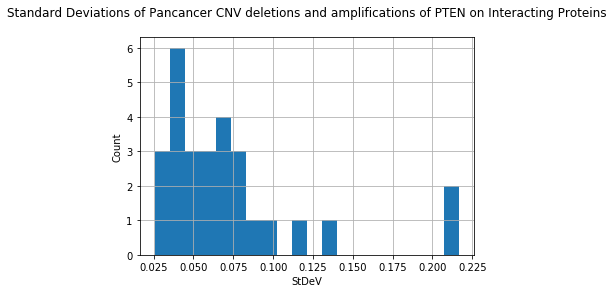

In [32]:
a = stdev.hist(bins = 20)
plt.title("Standard Deviations of Pancancer CNV deletions and amplifications of PTEN on Interacting Proteins\n")
plt.xlabel('StDeV')
plt.ylabel('Count')

In [ ]:
plt.rcParams['figure.figsize']=(10,8)
sns.set(font_scale = 1.3)
a = sns.distplot(stdev, bins = 20)

a.set_title("Standard Deviation Distribution for Pancancer PTEN Mutation Effect on Proteomics\n\n (Median of proteomics with Wildtype PTEN - Median of proteomics with Mutated PTEN)")
a.set(xlabel = 'StDeV', ylabel = 'Frequency')

Mean

In [ ]:
mean_df = stdev.mean()

In [ ]:
a = mean_df.hist(bins = 20)
plt.title("Distribution of the Mean between Cancers for PTEN Mutation Effect on all Proteins\n\n (Median of proteomics with Wildtype PTEN - Median of proteomics with Mutated PTEN)")
plt.xlabel('Mean')
plt.ylabel('Count')

In [ ]:
m_df = stdev.median()

In [ ]:
a = m_df.hist(bins = 20)
plt.title("Distribution of the Medians between Cancers for PTEN Mutation Effect on all Proteins\n\n (Median of proteomics with Wildtype PTEN - Median of proteomics with Mutated PTEN)")
plt.xlabel('Median')
plt.ylabel('Count')